# Линейная регрессия (100 баллов)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)


In [2]:
import statsmodels.api as sm # все, для работы с рядами
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса
from itertools import product # произведения множеств
import warnings # чтобы отключить предупреждения в Python

В файле auto.csv находятся данные, которые описывают характеристики 392 автомобилей.

А именно, в данных вы найдете следующие столбцы:
1. mpg — расход топлива (миль/галлон);
2. cylinders — количество цилиндров мотора;
3. displacement — объем мотора (куб. дюйм);
4. horsepower — мощность мотора (в лошадиных силах);
5. weight — вес (тысяч фунтов);
6. acceleration — время, за которое автомобиль разгоняется до 60 mph;
7. year — год автомобиля (по модулю 100);
8. origin — место производства (1 — Америка, 2 — Европа, 3 — Япония);
9. name — название автомобиля.

Задания
- Визуально проанализируйте взаимосвязь между расходом топлива и остальными переменными
    - базовый код написан
    - нужно проанализировать графики и прокомментировать наблюдения - обратите внимание на вопросы
    - по усмотрению можно сделать дополнительный анализ
- Подготовьте данные для построения линейной регрессии
---
- Постройте линейную регрессионную модель для предсказания расхода топлива по этим данным
- Интерпретируйте значения коэффициентов регрессии (влияние каждого признака на отклик). Какие признаки влияют на расход топлива и как?
---
- Проанализируйте остатки и проверьте корректность модели


In [3]:
df = pd.read_csv('auto.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Визуальный анализ (40 баллов)

- **(10 баллов)** Стоит ли использовать все признаки? Какую проблему мы можем наблюдать?

In [7]:
# Мы не можем использовать не числовые признаки, такие как название марки

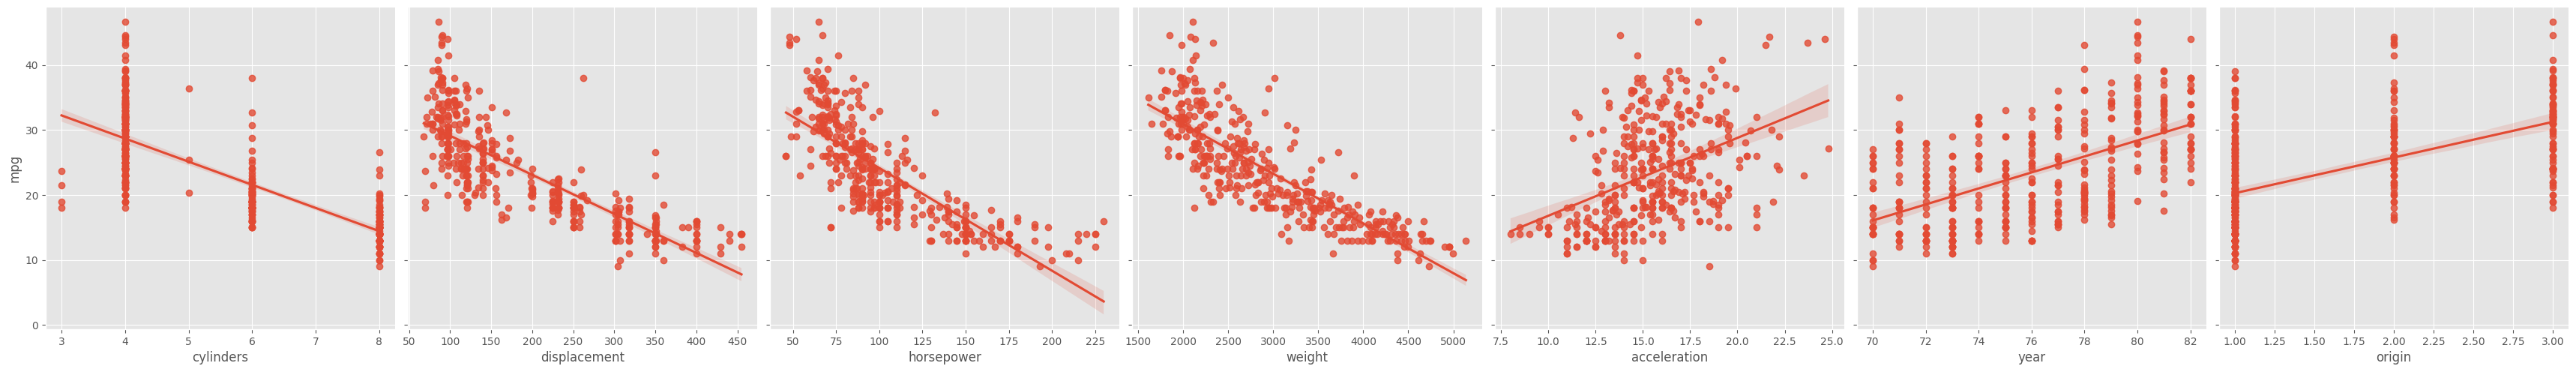

In [11]:
sns.pairplot(df, y_vars = "mpg", x_vars = [i for i in df.columns[1:-1]], height = 5, kind = "reg", diag_kind=None)

In [ ]:
# Визуально acceleration/ year и cylinders имеют достаточно слабую корреляцию с таргетом, но мы проверим это дополнительно в статистических тестах

- **(10 баллов)** Нужно ли логарифмирование?

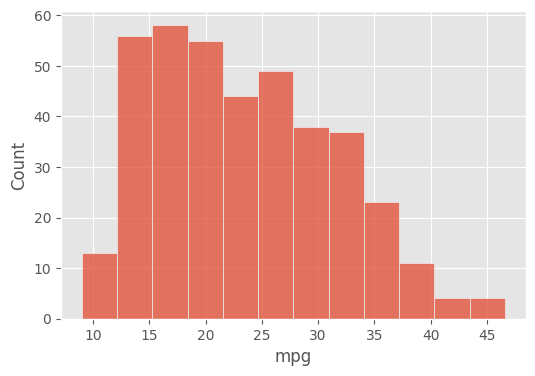

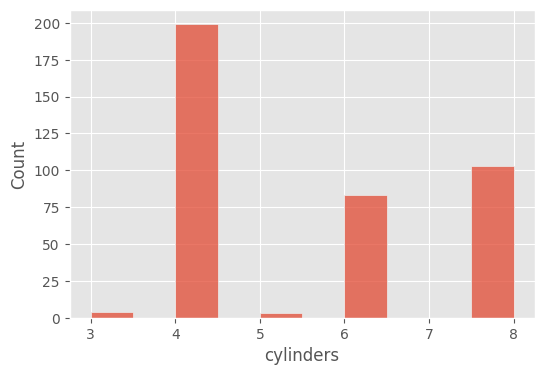

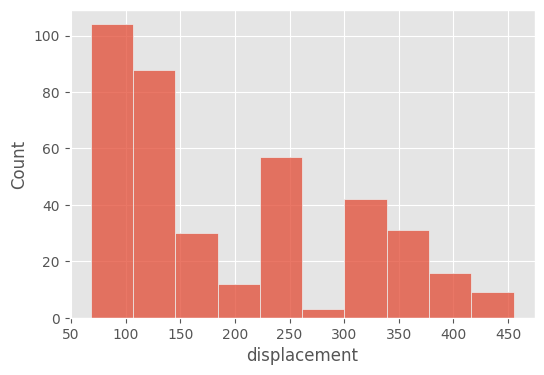

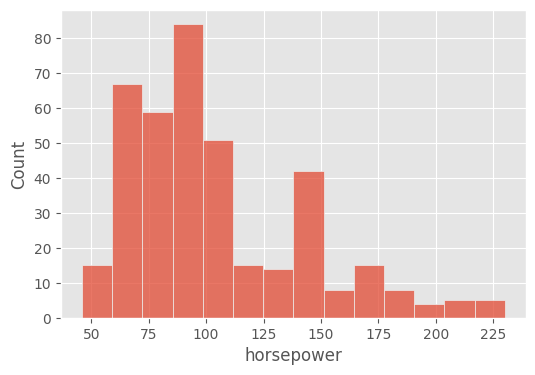

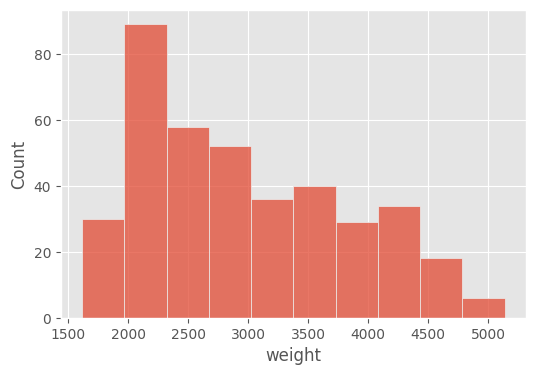

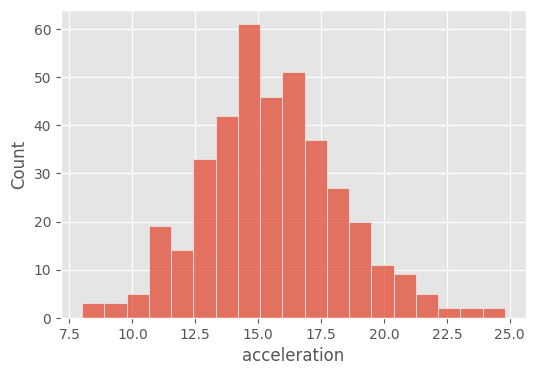

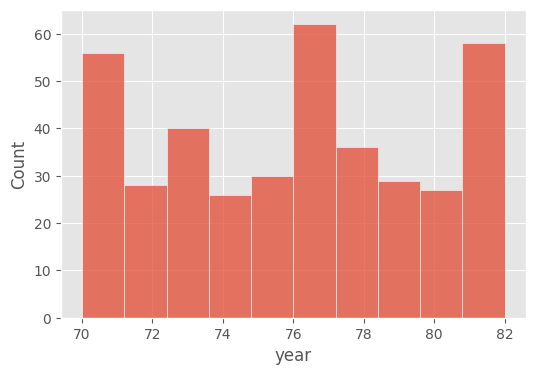

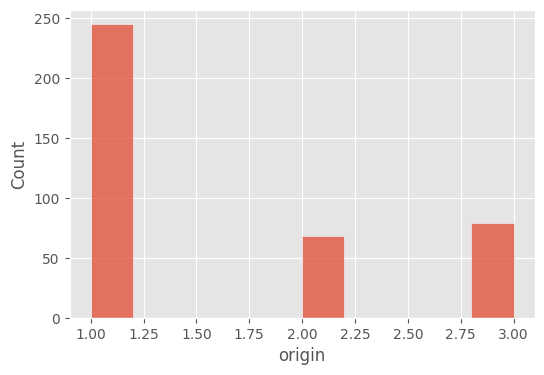

In [16]:
#Посмотрим на распределение данных
names = [i for i in df.columns[:-1]]
for i in names:
  plt.figure(figsize = (6, 4))
  sns.histplot(df[i])
  plt.show()

In [ ]:
# Можем увидеть сдвиг в данных (displacement и тд), который можно нормализовать логарифмированием, так что да, стоит применить логарифм

- **(10 баллов)** Все ли признаки действительно числовые?

Ответ: нет, признаки названия марок - это просто строки, а признаки страны производства - порядковые, хотя их бы хорошо сделать категориальными

- **(10 баллов)** Если окажется, что это не так, при этом на части признаков нельзя ввести порядок (условно, если орлу сопоставлять 1, решке 0, то 1 > 0, но на самом деле мы не можем сказать, больше ли орёл решки или нет), то закодируйте эти призка при помощи OneHotEncoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html (про него можно прочитать в слайдах второй лекции со слайда 96)

In [18]:
import sklearn
from sklearn.preprocessing import OneHotEncoder

In [32]:
# Давайте закодируем страну производства
encoder = OneHotEncoder(drop="first") # уберем первый столбец, чтобы избежать дамми-ловушки
encoded = encoder.fit_transform(df[["origin"]])
cols = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(["origin"]))
cols.head()

,origin_2,origin_3
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [37]:
df = df.drop(["name", "origin"], axis=1)

In [39]:
df = pd.concat([df,cols], axis=1)

## Регрессия (40 баллов)

- **(15 баллов)** Постройте линейную регрессионную модель для предсказания расхода топлива по этим данным.
- **(10 баллов)** Попробуйте улучшить модель: преобразовав признаки или же добавив новые (например, как в начале лекции, признак, равный произведению двух)
- **(15 баллов)** Интерпретируйте значения коэффициентов регрессии (влияние каждого признака на отклик). Какие признаки влияют на расход топлива и как? Проитерпретируйте также pvalue F-теста.

In [52]:
X = df.iloc[:,1:]
X =  sm.add_constant(X)
Y = df.iloc[:, :1]

In [53]:
# Давайте для начала посмотрим, какие данные мы можем удалить
model = sm.OLS(Y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          1.79e-139
Time:                        00:40:24   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.9546      4.677     -3.839   

In [54]:
# По статистике видно, что кол-во цилиндров, лошадиных сил, а также ускорение статистически незначимы, удалим их
X = X.drop(["acceleration", 'cylinders', 'horsepower'], axis = 1)

In [55]:
# Теперь давайте логарифмировать
Y = Y.apply(lambda x: np.log(x + 1))
X = X.apply(lambda x: np.log(x + 1))
X.head()

,const,displacement,weight,year,origin_2,origin_3
0,0.693147,5.730100,8.161946,4.26268,0.0,0.0
1,0.693147,5.860786,8.214465,4.26268,0.0,0.0
2,0.693147,5.765191,8.142354,4.26268,0.0,0.0
3,0.693147,5.720312,8.141481,4.26268,0.0,0.0
4,0.693147,5.713733,8.146130,4.26268,0.0,0.0


In [56]:
model = sm.OLS(Y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     580.1
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          5.07e-177
Time:                        00:40:41   Log-Likelihood:                 305.25
No. Observations:                 392   AIC:                            -598.5
Df Residuals:                     386   BIC:                            -574.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1856      0.920     -1.288   

In [ ]:
# Хм... стало получше стало, но не сильно.....давайте попробуем посмотреть на выполнение теоремы Гаусса-Маркова

## Анализ остатков и корректность модели (20 баллов)

Методами, рассказанными на лекции, посмотрите на выполнение предпосылок теоремы Гаусса-Маркова. Насколько хорошей получилась модель на ваш взгляд?

In [57]:
# Проверим на мультиколлинеарность
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["Value"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif)

        Feature         Value
0         const  12729.831659
1  displacement     12.630363
2        weight      9.796144
3          year      1.190126
4      origin_2      1.817449
5      origin_3      1.843690


In [59]:
# Так..с давайте посмотрим корреляция и тогда примем решение, что делать с displacement и weights
X.corr()


,const,displacement,weight,year,origin_2,origin_3
const,NaN,NaN,NaN,NaN,NaN,NaN
displacement,NaN,1.000000,0.942822,-0.329196,-0.387829,-0.490034
weight,NaN,0.942822,1.000000,-0.284892,-0.295207,-0.471213
year,NaN,-0.329196,-0.284892,1.000000,-0.036231,0.198332
origin_2,NaN,-0.387829,-0.295207,-0.036231,1.000000,-0.230157
origin_3,NaN,-0.490034,-0.471213,0.198332,-0.230157,1.000000


In [61]:
# Уберем displacement
X = X.drop("displacement", axis = 1)

In [63]:
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["Value"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif)
# Теперь все в норме

    Feature         Value
0     const  12357.187569
1    weight      1.756437
2      year      1.107915
3  origin_2      1.372248
4  origin_3      1.591537


In [64]:
model = sm.OLS(Y, X)
res = model.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     724.8
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          3.03e-178
Time:                        01:03:17   Log-Likelihood:                 304.70
No. Observations:                 392   AIC:                            -599.4
Df Residuals:                     387   BIC:                            -579.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0218      0.907     -1.127      0.2

In [ ]:
# Дарбин_Уотсон такой себе, идеально значение 2

In [65]:
# Финально проверим разброс остатков
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(res.resid, X.values)

(15.350406144379594,
 0.004026997017524046,
 3.9430595935755135,
 0.003770542230219954)

In [66]:
# Есть разброс, попробуем ввести корректировку
model = sm.OLS(Y, X)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     832.9
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          1.25e-188
Time:                        01:12:09   Log-Likelihood:                 304.70
No. Observations:                 392   AIC:                            -599.4
Df Residuals:                     387   BIC:                            -579.6
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0218      1.009     -1.013      0.3

Интерпретация:

Расход топлива имеет отрицательную зависимость от веса (при увеличении веса на 1% расход понизится на 0.85%)
Чем новее машина, тем больше у нее расход топлива
Японские автомобили в целом имеют больший расход
Остальные признаки не играют существенной роли